In [1]:
%load_ext autoreload
%autoreload 2

from scipy.sparse import dia_matrix
import inspect
from astropy.table import Table
import numpy as np  
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
%matplotlib widget
import sys

# widgets.FloatRangeSlider(value=[5, 7.5],readout_format='.3f')

In [2]:
a = Table.read('/Users/Vincent/Nextcloud/LAM/FIREBALL/2022/DetectorData/220204_darks_T183_1MHz/7000/220329_18H54m27/EMGAIN_7000.0/EXPTIME_100.0/HistogramSum.csv')

emgain=1455
RN=47
flux=0.052
smearing= 0.7
sCIC=0.009
x=a['col0']
y=a['col1']

n_pix = np.nansum( y[np.isfinite(y)]) # # 1e6#
n_pix

359229.6

interactive(children=(IntSlider(value=47, description='RN', layout=Layout(width='700px'), max=200), IntSlider(…

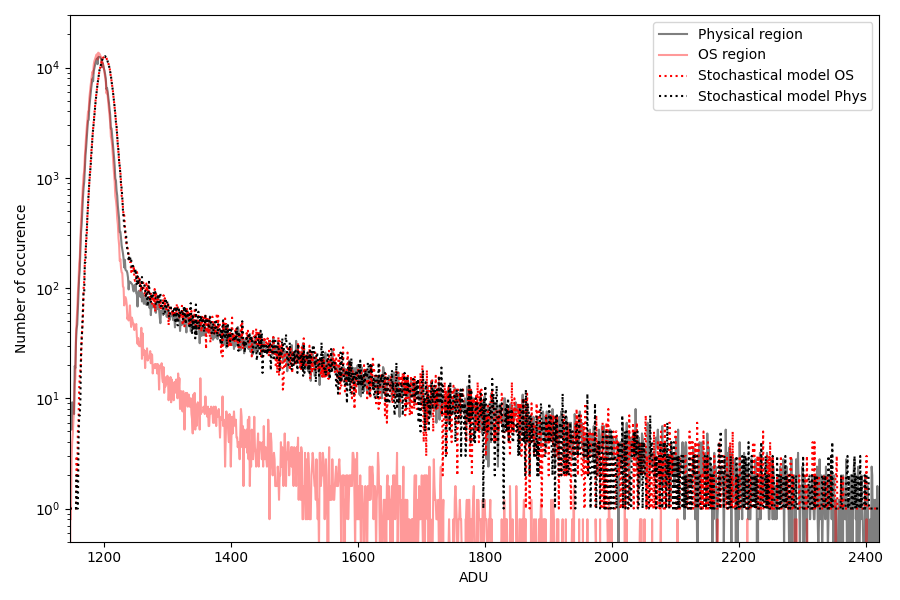

In [5]:
smearing1= 0.7
smearing2= 0.7




def EMCCDhist(
    x,
    bias=[1e3, 4.5e3, 1194],
    RN=[0, 200, 53],
    EmGain=[100, 10000, 5000],
    flux=[0.001, 1, 0.04],
    smearing=[0, 1, 0.01],
    sCIC=[0, 1, 0],
):
    # def EMCCDhist(x, bias=[1e3, 4.5e3,1194], RN=[0,200,53], EmGain=[100, 10000,5000], flux=[0.001, 1,0.04], smearing=[0, 3,0.31], sCIC=[0,1,0],SmearExpDecrement=[1.5e3,1.5e5,15e4]):
    from scipy.sparse import dia_matrix
    import inspect
    from astropy.table import Table
    from matplotlib.widgets import Button
    import numpy as np

    if bias > 1500:
        ConversionGain = 0.53  # 1/4.5 #ADU/e-  0.53 in 2018
    else:
        ConversionGain = 1 / 4.5  # ADU/e-  0.53 in 2018

    # def variable_smearing_kernels(image, Smearing=1.5, SmearExpDecrement=50000):
    #     """Creates variable smearing kernels for inversion
    #     """
    #     import numpy as np
    #     n=6
    #     smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
    #     smearing_kernels = np.exp(-np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length)
    #     smearing_kernels /= smearing_kernels.sum(axis=0)
    #     return smearing_kernels
    def variable_smearing_kernels(
        image, Smearing=0.7, SmearExpDecrement=50000, type_="exp"
    ):
        """Creates variable smearing kernels for inversion
        """
        import numpy as np

        n = 15
        smearing_length = Smearing * np.exp(-image / SmearExpDecrement)
        if type_ == "exp":
            smearing_kernels = np.exp(
                -np.arange(n)[:, np.newaxis, np.newaxis] / smearing_length
            )
        else:
            assert 0 <= Smearing <= 1
            smearing_kernels = np.power(Smearing, np.arange(n))[
                :, np.newaxis, np.newaxis
            ] / np.ones(smearing_length.shape)
        smearing_kernels /= smearing_kernels.sum(axis=0)
        return smearing_kernels

    def simulate_fireball_emccd_hist(
        x,
        ConversionGain,
        EmGain,
        Bias,
        RN,
        Smearing,
        SmearExpDecrement,
        n_registers,
        flux,
        sCIC=0,
    ):
        """Silumate EMCCD histogram
        """
        import numpy as np

        # try:
        #     y = globals()["y"]
        #     # print('len y=',len(y))
        #     # print(' y=',y[y>1])
        #     # print('sum',np.nansum(y[np.isfinite(y)]))
        #     n_pix = np.nansum(10 ** y[np.isfinite(10 ** y)])  # 1e6#
        #     # print("global", np.sum(10 ** y), n_pix)
        # except TypeError:
        #     n_pix = 10 ** 6.3
        #     # print("fixed", np.sum(10 ** y), n_pix)
        n = 1
        # print('npix', n_pix)
        im = np.zeros(int(n_pix))  #
        im = np.zeros((1000, int(n_pix / 1000)))
        # im = np.zeros((1000,10+1))
        # factor = 1#np.log(2)
        # EmGain *= factor
        # imaADU = np.random.gamma(flux, EmGain, size=im.shape)
        # print(np.max([flux,0]),flux,EmGain)
        imaADU = np.random.gamma(
            np.random.poisson(np.nanmax([flux, 0]), size=im.shape), abs(EmGain)
        )
        # Add pCIC (no interest, as flux)
        # imaADU[np.random.rand(size[1],size[0]) <  p_pCIC] += 1

        # pixels in which sCIC electron might appear
        p_sCIC = sCIC / np.mean(
            1 / np.power(EmGain * ConversionGain, np.arange(604) / 604)
        )
        # / np.mean(1 / np.power(EmGain * ConversionGain, np.arange(604) / 604))

        id_scic = (
            np.random.rand(im.shape[0], im.shape[1])
            < p_sCIC
            # np.random.rand(im.shape[0])< p_sCIC
        )  # sCIC  # sCIC positions
        # stage of the EM register at which each sCIC e- appear
        register = np.random.randint(1, n_registers, size=id_scic.sum())
        # Compute and add the partial amplification for each sCIC pixel
        imaADU[id_scic] += np.random.exponential(
            np.power(EmGain, register / n_registers)
        )
        imaADU *= ConversionGain

        if Smearing > 0:
            smearing_kernels = variable_smearing_kernels(
                imaADU, Smearing, SmearExpDecrement
            )
            offsets = np.arange(6)
            A = dia_matrix(
                (smearing_kernels.reshape((6, -1)), offsets),
                shape=(imaADU.size, imaADU.size),
            )
            imaADU = A.dot(imaADU.ravel()).reshape(imaADU.shape)
        read_noise = np.random.normal(0, RN * ConversionGain, size=im.shape)
        imaADU += Bias
        imaADU += read_noise
        range = [np.nanmin(x), np.nanmax(x)]
        # n, bins = np.histogram(imaADU.flatten(), range=range, bins=len(x))
        # print(x)
        n, bins = np.histogram(imaADU.flatten(), bins=[x[0] - 1] + list(x))
        n_conv = 1
        return np.convolve(n, np.ones(n_conv) / n_conv, mode="same")

    y = simulate_fireball_emccd_hist(
        x=x,
        ConversionGain=ConversionGain,  # 0.53,
        EmGain=EmGain,
        Bias=bias,
        RN=RN,
        Smearing=smearing,
        SmearExpDecrement=1e5,  # 1e4,  # 1e5 #2022=1e5, 2018=1e4...
        n_registers=604,
        flux=flux,
        sCIC=sCIC,
    )
    y[y == 0] = 1
    y /= x[1] - x[0]
    # print("len(y)", np.sum(y))
    return np.log10(y)



fig, ax = plt.subplots(figsize=(9,6))
ax.semilogy(a['col0'],a['col1'],c='k',alpha=0.5,label='Physical region')
ax.semilogy(a['col0'],a['col2'],c='r',alpha=0.4,label='OS region')
# anal1=ax.semilogy(x,10**EMCCD(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing1, sCIC=sCIC),c='b',label='Analytical model')
stoch1=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing1, sCIC=sCIC),':',c='r',label='Stochastical model OS')
# anal2=ax.semilogy(x,10**EMCCD(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing2, sCIC=sCIC),c='k',label='Analytical model')
stoch2=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing2, sCIC=sCIC),':',c='k',label='Stochastical model Phys')
# ax.semilogy(a['col0'],np.log10(a['col1']))
ax.legend(loc='upper right')
ax.set_xlabel('ADU')
ax.set_ylabel('Number of occurence')
ax.set_xlim((x.min(),x.max()))
ax.set_ylim((5e-1,3e4))
fig.tight_layout()


def view_image( RN, bias,EmGain, flux_w, smearing, sCIC):#,SmearExpDecrement):
    flux1, flux2 = flux_w
    # RN1 = RN
    # EmGain1 = EmGain
    # smearing1,smearing2=smearing
    # sCIC1,sCIC2=sCIC
    stoch1 = EMCCDhist(x, bias, RN, EmGain, flux1, smearing, sCIC)#,SmearExpDecrement=10**exp1)
    stoch2 = EMCCDhist(x, bias, RN, EmGain, flux2, smearing, sCIC)#,SmearExpDecrement=10**exp2)
    anal1 = EMCCD(x, bias, RN, EmGain, flux1, smearing, sCIC)#,SmearExpDecrement=10**exp1)
    anal2 = EMCCD(x, bias, RN, EmGain, flux2, smearing, sCIC)#,SmearExpDecrement=10**exp2)
    # ax.lines[2].set_data(x,10**anal1)
    ax.lines[2].set_data(x,10**stoch1)

    # ax.lines[4].set_data(x,10**anal2)
    ax.lines[3].set_data(x,10**stoch2)

width = '700px'
bias_w = widgets.IntSlider( min=1100, max=1600,value=a['col0'][np.argmax(a['col1'])], layout=Layout(width=width))
rn_w = widgets.IntSlider( min=0, max=200,value=RN, layout=Layout(width=width))
gain_w = widgets.IntSlider( min=500, max=1500,value=emgain, layout=Layout(width=width))

flux_w =  widgets.FloatRangeSlider(value=[0,flux],min=0.00,max=0.5,step=0.001,readout_format='.1e', layout=Layout(width=width))
smearing_w =  widgets.FloatSlider( min=0.0, max=1.8,value=smearing, layout=Layout(width=width),readout_format='.1e')
sCIC_w =  widgets.FloatSlider( min=0.0, max=0.1,value=sCIC,step=0.001, layout=Layout(width=width),readout_format='.1e')
# exp_w = widgets.FloatRangeSlider( min=3, max=5,value=[4,4], layout=Layout(width='500px'))

a = interact(view_image, bias=bias_w,RN=rn_w, EmGain=gain_w, flux_w=flux_w, smearing=smearing_w, sCIC=sCIC_w)#,SmearExpDecrement=exp)

interactive(children=(IntRangeSlider(value=(50, 50), description='RN', layout=Layout(width='700px'), max=200),…

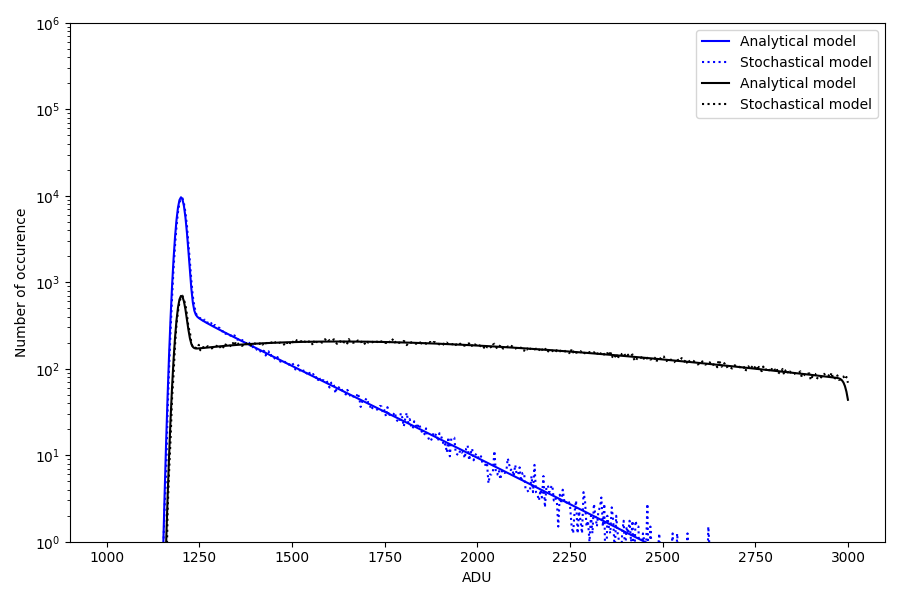

In [10]:
sys.path.append("../../../../pyds9plugin")
from pyds9plugin.Macros.Fitting_Functions.functions import EMCCD, EMCCDhist

a = Table.read('/Users/Vincent/Nextcloud/LAM/FIREBALL/2022/DetectorData/220204_darks_T183_1MHz/7000/220329_18H54m27/EMGAIN_7000.0/EXPTIME_100.0/HistogramSum.csv')
emgain=800
RN=50
flux=0.3
smearing1, smearing2 = 0,0.8
sCIC=0.01
x=np.linspace(1000,3000,500)



fig, ax = plt.subplots(figsize=(9,6))
anal1=ax.semilogy(x,10**EMCCD(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing1, sCIC=sCIC),c='b',label='Analytical model')
stoch1=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing1, sCIC=sCIC),':',c='b',label='Stochastical model')

anal2=ax.semilogy(x,10**EMCCD(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing2, sCIC=sCIC),c='k',label='Analytical model')
stoch2=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing2, sCIC=sCIC),':',c='k',label='Stochastical model')

# ax.semilogy(a['col0'],np.log10(a['col1']))#
#ax.semilogy(a['col0'],a['col1'])

ax.legend(loc='upper right')
ax.set_xlabel('ADU')
ax.set_ylabel('Number of occurence')
ax.set_ylim((1,1e6))
fig.tight_layout()

def view_image( RN, EmGain, flux_w, smearing, sCIC):#,SmearExpDecrement):
    flux1, flux2 = flux_w
    RN1, RN2 = RN
    EmGain1, EmGain2 = EmGain
    smearing1,smearing2=smearing
    sCIC1,sCIC2=sCIC
    stoch1 = EMCCDhist(x, 1200, RN1, EmGain1, flux1, smearing1, sCIC1)#,SmearExpDecrement=10**exp1)
    stoch2 = EMCCDhist(x, 1200, RN2, EmGain2, flux2, smearing2, sCIC2)#,SmearExpDecrement=10**exp2)
    anal1 = EMCCD(x, 1200, RN1, EmGain1, flux1, smearing1, sCIC1)#,SmearExpDecrement=10**exp1)
    anal2 = EMCCD(x, 1200, RN2, EmGain2, flux2, smearing2, sCIC2)#,SmearExpDecrement=10**exp2)
    ax.lines[0].set_data(x,10**anal1)
    ax.lines[1].set_data(x,10**stoch1)

    ax.lines[2].set_data(x,10**anal2)
    ax.lines[3].set_data(x,10**stoch2)

width = '700px'
rn_w = widgets.IntRangeSlider( min=0, max=200,value=[RN,RN], layout=Layout(width=width))
gain_w = widgets.IntRangeSlider( min=500, max=1500,value=[emgain,1500], layout=Layout(width=width))

flux_w =  widgets.FloatRangeSlider(value=[flux, 3],min=0.001,max=5,step=0.001,readout_format='.1e', layout=Layout(width=width))
smearing_w =  widgets.FloatRangeSlider( min=0.0, max=1,value=[0,0], layout=Layout(width=width),readout_format='.1e')
sCIC_w =  widgets.FloatRangeSlider( min=0.0, max=0.3,value=[sCIC,sCIC],step=0.001, layout=Layout(width=width),readout_format='.1e')
# exp_w = widgets.FloatRangeSlider( min=3, max=5,value=[4,4], layout=Layout(width='500px'))

a = interact(view_image, RN=rn_w, EmGain=gain_w, flux_w=flux_w, smearing=smearing_w, sCIC=sCIC_w)#,SmearExpDecrement=exp)

interactive(children=(IntRangeSlider(value=(50, 50), description='RN', layout=Layout(width='500px'), max=200),…

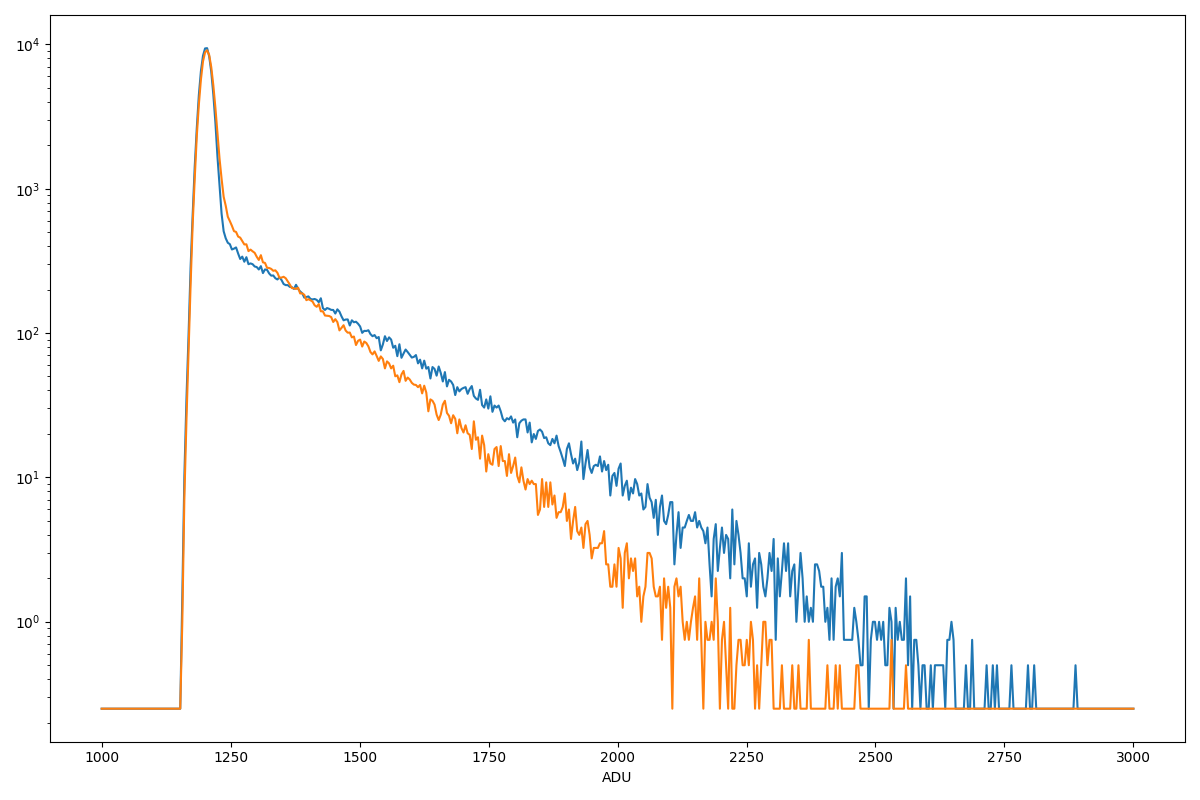

In [3]:

fig, ax = plt.subplots(figsize=(12,8))
l=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing1, sCIC=sCIC))
l2=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing2, sCIC=sCIC))
ax.set_xlabel('ADU')
ax.set_xlabel('ADU')
fig.tight_layout()
# plt.show()


# @widgets.interact(bias=(1000, 2000,1194), RN=(0.,200.,53.), EmGain=(100, 10000,5000), flux=(0.001, 1,0.04), smearing=(0, 3,0.31), sCIC=(0,1,0.1))
def view_image( RN, EmGain, flux, smearing, sCIC):#,SmearExpDecrement):
    # with widgets.Output():
    flux1, flux2 = flux
    RN1, RN2 = RN
    EmGain1, EmGain2 = EmGain
    smearing1,smearing2=smearing
    sCIC1,sCIC2=sCIC
    # exp1,exp2 = SmearExpDecrement
    emccd = EMCCDhist(x, 1200, RN1, EmGain1, flux1, smearing1, sCIC1)#,SmearExpDecrement=10**exp1)
    emccd2 = EMCCDhist(x, 1200, RN2, EmGain2, flux2, smearing2, sCIC2)#,SmearExpDecrement=10**exp2)
    ax.lines[0].set_data(x,10**emccd)
    ax.lines[1].set_data(x,10**emccd2)


 
rn_w = widgets.IntRangeSlider( min=0, max=200,value=[RN,RN], layout=Layout(width='500px'))
gain_w = widgets.IntRangeSlider( min=500, max=1500,value=[emgain,emgain], layout=Layout(width='500px'))

flux_w =  widgets.FloatRangeSlider(value=[flux, flux],min=0.001,max=1,step=0.001,readout_format='.1f', layout=Layout(width='500px'))
smearing_w =  widgets.FloatRangeSlider( min=0.0, max=3,value=[smearing1,smearing2], layout=Layout(width='500px'),readout_format='.2f')
sCIC_w =  widgets.FloatRangeSlider( min=0.0, max=1,value=[sCIC,sCIC], layout=Layout(width='500px'),readout_format='.2f')
exp_w = widgets.FloatRangeSlider( min=3, max=5,value=[4,4], layout=Layout(width='500px'))
a = interact(view_image, RN=rn_w, EmGain=gain_w, flux=flux_w, smearing=smearing_w, sCIC=sCIC_w)#,SmearExpDecrement=exp)

In [9]:
# np.savetxt("/tmp/xy.txt", np.array([x,np.log10(y)]).T)
# cat_all['hist_os']

<ipython-input-4-2a34ad515209>:47: RuntimeWarning: invalid value encountered in log10
  np.savetxt("/tmp/xy.txt", np.array([x, np.log10(np.log10(y))]).T)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.03230409826920338 nan


TraitError: setting lower > upper

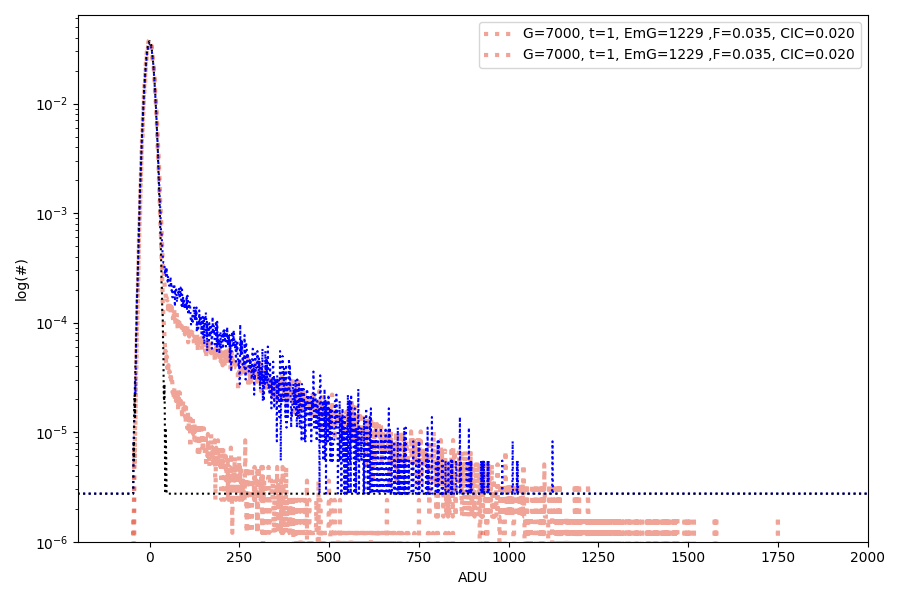

In [4]:
gain_f= 'gain_ls'
flux_f='flux_ls'
gain_f='Gain1'
flux_f='Flux1'
bias='bias_fit'

cat = Table.read('/Users/Vincent/Nextcloud/LAM/FIREBALL/2022/DetectorData/220204_darks_T183_1MHz/HeaderCatalogFIREBall.ecsv')

cat['sCIC_ls']=0.01
from pyds9plugin.Macros.Fitting_Functions.functions import EMCCD, EMCCDhist

# cat = Table.read('/Users/Vincent/Nextcloud/LAM/FIREBALL/2022/DetectorData/220204_darks_T183_1MHz/HeaderCatalog.ecsv')

colors= ['#E24A33','#348ABD','#988ED5','#777777','#FBC15E','#8EBA42','#FFB5B8'] + ['#E24A33','#348ABD','#988ED5','#777777','#FBC15E','#8EBA42','#FFB5B8']
np.seterr(divide = 'ignore') 
lw=3
fig,ax = plt.subplots(figsize=(9,6))
gains=7000
for gain,ls,off in zip([gains],[':',':'],[0,2]):
    texps = np.sort(np.array(np.unique(cat['EXPTIME']),dtype=float))
    texps.sort()
    for texp,c,cic in zip([1,50,150],colors,[0.02,0.03,0.07]):#texps
        subcat = cat[(cat['EMGAIN']==gain) & (cat['EXPTIME']==texp)]
        # print(len(subcat),texp,gain)
        if (len(subcat)>0) & (int(gain)>0) :#& (int(texp) in [1,5,50,150]):
            bias=np.mean(subcat[bias])
            ron=np.mean(subcat['RON'])
            EmGain=np.median(subcat[gain_f])
            flux=np.median(subcat[flux_f])
            l = 'G=%s, t=%s, EmG=%i ,F=%0.3f, CIC=%0.3f'%(gain,texp,EmGain,flux,cic)
#             l=None
            x,y = np.mean(np.array(subcat['bins']),axis=0), np.median(np.array(subcat['hist']),axis=0)#)
            x_os,y_os = np.mean(np.array(subcat['bins']),axis=0), np.median(np.array(subcat['hist_os']),axis=0)#)

            l1=ax.semilogy(x,y/y.sum(),label=l,lw=lw,ls=ls,c=c,alpha=0.5)
            l2=ax.semilogy(x_os,y_os/y_os.sum(),label=l,lw=lw,ls=ls,c=c,alpha=0.5)

            model = EMCCDhist(x,bias,ron,EmGain,flux*np.log(2),0.00,cic)
            constant = np.nanmax(y)/np.nanmax(model)
            # l2=ax.plot(x,model*constant+off,lw=lw,ls='-',c=c)
            # model_to_fit_stochastic_smearing_cic = lambda bin_center,cic : EMCCDhist(bin_center,bias,ron,EmGain,flux*np.log(2),0,cic )*constant+off
            # p0=[0.08]
            # mask_smearing_CIC = (x>1200)&(x<1350)&(np.log10(y)>0)
            # popt2, pcov2 = curve_fit(model_to_fit_stochastic_smearing_cic,x[mask_smearing_CIC],np.log10(y[mask_smearing_CIC]),p0=p0,method='dogbox',bounds=([0],[1]))#,bounds=([0,0],[1,1])
            # print(popt2)
            # ax.plot(x[mask_smearing_CIC],model_to_fit_stochastic_smearing_cic(x[mask_smearing_CIC],*popt2))
np.savetxt("/tmp/xy.txt", np.array([x, np.log10(np.log10(y))]).T)
from pyds9plugin.Macros.Fitting_Functions.functions import EMCCD, EMCCDhist
ax.legend()#ncol=len(gains))
ax.set_xlim(xmin=-200,xmax=2000)
ax.set_ylim(ymin=1e-6)
ax.set_xlabel('ADU')
ax.set_ylabel('log(#)')
fig.tight_layout()


bias = x[np.argmax(y)]#cat['bias'])
RN= np.mean(cat['RON'])
Emgain= np.mean(cat[gain_f][cat['EMGAIN']==gains])
flux1, flux2= np.mean(cat[flux_f][(cat['EMGAIN']==gains) & (cat['EXPTIME']==texps[0])]), np.mean(cat[flux_f][(cat['EMGAIN']==gains) & (cat['EXPTIME']==texps[-1])])
CIC1, CIC2= np.mean(cat['sCIC_ls'][(cat['EMGAIN']==gains) & (cat['EXPTIME']==texps[0])]), np.mean(cat['sCIC_ls'][(cat['EMGAIN']==gains) & (cat['EXPTIME']==texps[-1])])

print(flux1, flux2)
y1 = 10**EMCCDhist(x, bias=bias, RN=RN, EmGain=emgain, flux=flux1, smearing=0, sCIC=CIC1)
y2 = 10**EMCCDhist(x, bias=bias, RN=RN, EmGain=emgain, flux=flux2, smearing=0, sCIC=CIC2)
# print(np.log10(y2.sum()))
anal1=ax.semilogy(x,y1/y1.sum(),'b:',label='Analytical model')
anal2=ax.semilogy(x,y2/y2.sum(),'k:',label='Analytical model')
# stoch1=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing1, sCIC=sCIC),':',c='b',label='Stochastical model')
# stoch2=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing2, sCIC=sCIC),':',c='k',label='Stochastical model')
# print(x[np.argmax(y1)])
# print(x[np.argmax(y2)])



def view_image( RN, EmGain, flux_w, smearing, sCIC):#,SmearExpDecrement):
    # with widgets.Output():
    flux1, flux2 = flux_w
    RN1, RN2 = RN
    EmGain1, EmGain2 = EmGain
    smearing1,smearing2=smearing
    sCIC1,sCIC2=sCIC
    # exp1,exp2 = SmearExpDecrement
    # stoch1 = EMCCDhist(x, 1200, RN1, EmGain1, flux1, smearing1, sCIC1)#,SmearExpDecrement=10**exp1)
    # stoch2 = EMCCDhist(x, 1200, RN2, EmGain2, flux2, smearing2, sCIC2)#,SmearExpDecrement=10**exp2)
    anal1 = 10**EMCCDhist(x, bias, RN1, EmGain1, flux1, smearing1, sCIC1)#,SmearExpDecrement=10**exp1)
    anal2 = 10**EMCCDhist(x, bias, RN2, EmGain2, flux2, smearing2, sCIC2)#,SmearExpDecrement=10**exp2)
    ax.lines[-1].set_data(x,anal1/anal1.sum())
    ax.lines[-2].set_data(x,anal2/anal2.sum())

style = {}#{'description_width': 'initial'}

rn_w = widgets.IntRangeSlider( min=0, max=200,value=[RN,RN], layout=Layout(width='500px'))
gain_w = widgets.IntRangeSlider( min=500, max=2500,value=[Emgain,Emgain], layout=Layout(width='500px'))
flux_w =  widgets.FloatRangeSlider(value=[flux1,flux2],min=0.0001,max=1,step=0.001,readout_format='.1e', layout=Layout(width='500px',max_width='1900pix'),style=style)
smearing_w =  widgets.FloatRangeSlider( min=0.0, max=1,step=0.01,value=[0,0], layout=Layout(width='500px'),readout_format='.1e')
sCIC_w =  widgets.FloatRangeSlider( min=0.0, max=1,value=[CIC1,CIC2], layout=Layout(width='500px'),readout_format='.1e',step=0.01)
a = interact(view_image, RN=rn_w, EmGain=gain_w, flux_w=flux_w, smearing=smearing_w, sCIC=sCIC_w)#,SmearExpDecrement=widgets.FloatRangeSlider( min=3, max=5,value=[4,4], layout=Layout(width='500px')))


0.03230409826920338 nan


/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3472: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/Vincent/opt/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TraitError: setting lower > upper

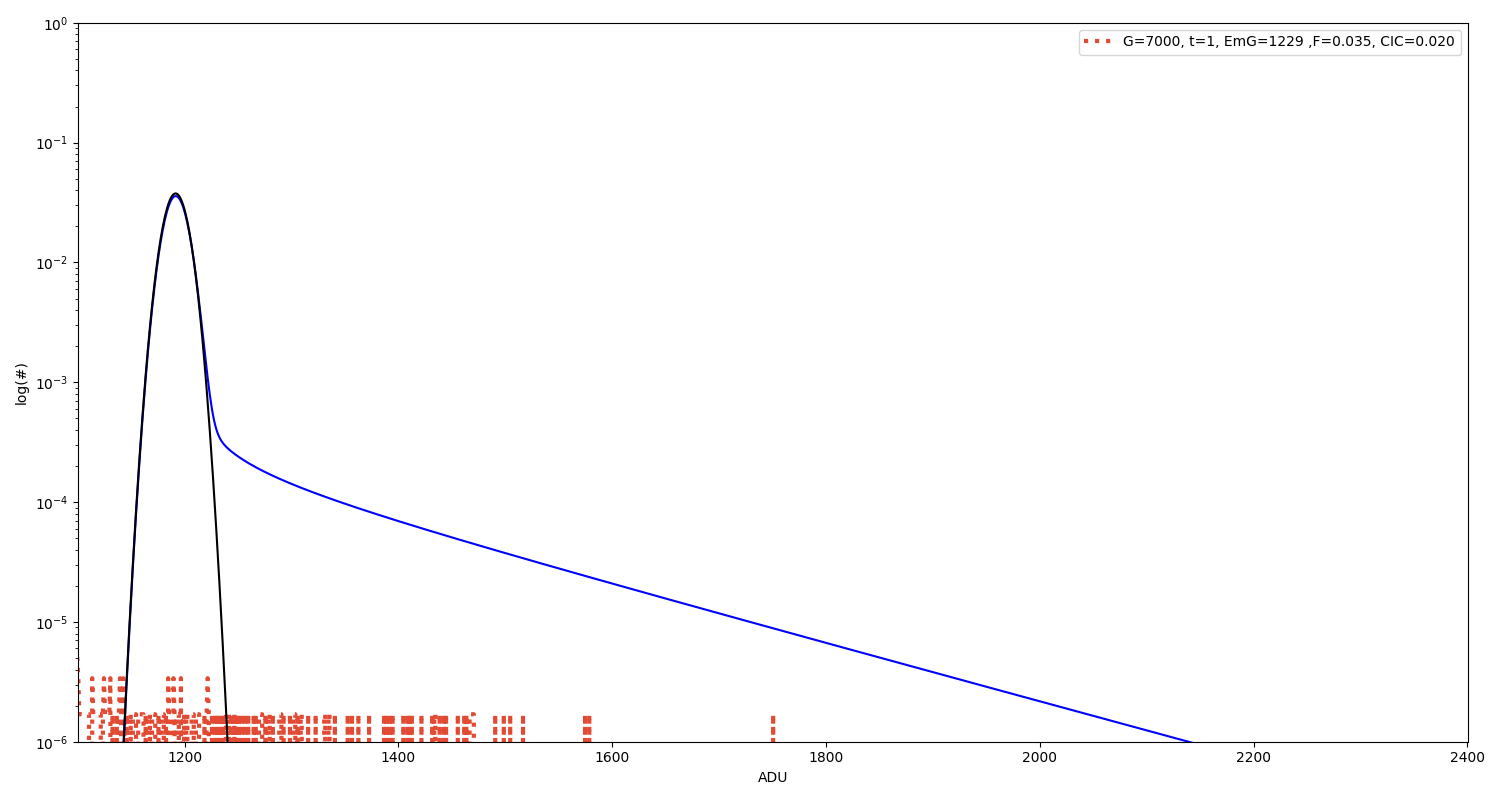

In [5]:
fig,ax = plt.subplots(figsize=(15,8))
gains=[7000]
for gain,ls,off in zip(gains,[':',':'],[0,2]):
    texps = np.sort(np.array(np.unique(cat['EXPTIME']),dtype=float))
    texps.sort()
    for texp,c,cic in zip([1,50,150],colors,[0.02,0.03,0.07]):#texps
        subcat = cat[(cat['EMGAIN']==gain) & (cat['EXPTIME']==texp)]
        if (len(subcat)>0) & (int(gain)>0) :#& (int(texp) in [1,5,50,150]):
            bias=np.mean(subcat['bias_fit'])
            ron=np.mean(subcat['RON'])
            EmGain=np.median(subcat[gain_f])
            flux=np.median(subcat[flux_f])
            
            l = 'G=%s, t=%s, EmG=%i ,F=%0.3f, CIC=%0.3f'%(gain,texp,EmGain,flux,cic)
            x,y = np.mean(np.array(subcat['bins']),axis=0), np.median(np.array(subcat['hist']),axis=0)#)
            l1=ax.semilogy(x,y/y.sum(),label=l,lw=lw,ls=ls,c=c)#+off
            model = EMCCDhist(x,bias,ron,EmGain,flux*np.log(2),0.00,cic)
            constant = np.nanmax(y)/np.nanmax(model)
            # l2=ax.plot(x,model*constant+off,lw=lw,ls='-',c=c)
            # model_to_fit_stochastic_smearing_cic = lambda bin_center,cic : EMCCDhist(bin_center,bias,ron,EmGain,flux*np.log(2),0,cic )*constant+off
            # p0=[0.08]
            # mask_smearing_CIC = (x>1200)&(x<1350)&(np.log10(y)>0)
            # popt2, pcov2 = curve_fit(model_to_fit_stochastic_smearing_cic,x[mask_smearing_CIC],np.log10(y[mask_smearing_CIC]),p0=p0,method='dogbox',bounds=([0],[1]))#,bounds=([0,0],[1,1])
            # print(popt2)
            # ax.plot(x[mask_smearing_CIC],model_to_fit_stochastic_smearing_cic(x[mask_smearing_CIC],*popt2))
np.savetxt("/tmp/xy.txt", np.array([x, y]).T)
from pyds9plugin.Macros.Fitting_Functions.functions import EMCCD, EMCCDhist
ax.legend(ncol=len(gains))
ax.set_xlim(xmin=1100,xmax=2400)
ax.set_ylim(ymin=1e-6,ymax=1)
ax.set_xlabel('ADU')
ax.set_ylabel('log(#)')
fig.tight_layout()



bias = np.mean(cat['bias'])
RN= np.mean(cat['RON'])
Emgain= np.mean(cat[gain_f][cat['EMGAIN']==gains])
flux1, flux2= np.mean(cat[flux_f][(cat['EMGAIN']==gains) & (cat['EXPTIME']==texps[0])]), np.mean(cat[flux_f][(cat['EMGAIN']==gains) & (cat['EXPTIME']==texps[-1])])
CIC1, CIC2= np.mean(cat['sCIC_ls'][(cat['EMGAIN']==gains) & (cat['EXPTIME']==texps[0])]), np.mean(cat['sCIC_ls'][(cat['EMGAIN']==gains) & (cat['EXPTIME']==texps[-1])])

print(flux1, flux2)
y1 = 10**EMCCD(x, bias=bias, RN=RN, EmGain=emgain, flux=flux1, smearing=0, sCIC=CIC1)
y2 = 10**EMCCD(x, bias=bias, RN=RN, EmGain=emgain, flux=flux2, smearing=0, sCIC=CIC2)
anal1=ax.semilogy(x,y1/y1.sum(),c='b',label='Analytical model')
anal2=ax.semilogy(x,y2/y2.sum(),c='k',label='Analytical model')
# stoch1=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing1, sCIC=sCIC),':',c='b',label='Stochastical model')
# stoch2=ax.semilogy(x,10**EMCCDhist(x, bias=1200, RN=RN, EmGain=emgain, flux=flux, smearing=smearing2, sCIC=sCIC),':',c='k',label='Stochastical model')
# print(x[np.argmax(y1)])
# print(x[np.argmax(y2)])



def view_image( RN, EmGain, flux_w, smearing, sCIC):#,SmearExpDecrement):
    # with widgets.Output():
    flux1, flux2 = flux_w
    RN1, RN2 = RN
    EmGain1, EmGain2 = EmGain
    smearing1,smearing2=smearing
    sCIC1,sCIC2=sCIC
    # exp1,exp2 = SmearExpDecrement
    # stoch1 = EMCCDhist(x, 1200, RN1, EmGain1, flux1, smearing1, sCIC1)#,SmearExpDecrement=10**exp1)
    # stoch2 = EMCCDhist(x, 1200, RN2, EmGain2, flux2, smearing2, sCIC2)#,SmearExpDecrement=10**exp2)
    anal1 = 10**EMCCD(x, bias, RN1, EmGain1, flux1, smearing1, sCIC1)#,SmearExpDecrement=10**exp1)
    anal2 = 10**EMCCD(x, bias, RN2, EmGain2, flux2, smearing2, sCIC2)#,SmearExpDecrement=10**exp2)
    ax.lines[-1].set_data(x,anal1/anal1.sum())
    ax.lines[-2].set_data(x,anal2/anal2.sum())


rn_w = widgets.IntRangeSlider( min=0, max=200,value=[RN,RN], layout=Layout(width='500px'))
gain_w = widgets.IntRangeSlider( min=500, max=1500,value=[Emgain,Emgain], layout=Layout(width='500px'))
flux_w =  widgets.FloatRangeSlider(value=[flux1,flux2],min=0.001,max=1,step=0.001,readout_format='.2f', layout=Layout(width='500px'))
smearing_w =  widgets.FloatRangeSlider( min=0.0, max=1,value=[0,0], layout=Layout(width='500px'),readout_format='.2f')
sCIC_w =  widgets.FloatRangeSlider( min=0.0, max=1,value=[CIC1,CIC2], layout=Layout(width='500px'),readout_format='.2f',step=0.01)
a = interact(view_image, RN=rn_w, EmGain=gain_w, flux_w=flux_w, smearing=smearing_w, sCIC=sCIC_w)#,SmearExpDecrement=widgets.FloatRangeSlider( min=3, max=5,value=[4,4], layout=Layout(width='500px')))



In [4]:


# x=np.linspace(1000,3000,100)
# fig, ax = plt.subplots(figsize=(12,8))
# l=ax.plot(x,EMCCDhist(x, bias=1194, RN=50, EmGain=1000, flux=0.001, smearing=0.0, sCIC=0.01))
# # l2=ax.plot(x,EMCCDhist(x, bias=1194, RN=50, EmGain=1000, flux=0.001, smearing=0.0, sCIC=0.01))

# fig.tight_layout()
# # plt.show()
# from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox


# # @widgets.interact(bias=(1000, 2000,1194), RN=(0.,200.,53.), EmGain=(100, 10000,5000), flux=(0.001, 1,0.04), smearing=(0, 3,0.31), sCIC=(0,1,0.1))
# def view_image(bias, RN, EmGain, flux, smearing, sCIC):
#     with widgets.Output():
#         print(bias)
#         emccd = EMCCDhist(x, bias, RN, EmGain, flux, smearing, sCIC)
#     #     ax.plot(x,emccd)
#         ax.lines[0].set_data(x,emccd)

# bias = widgets.IntSlider( min=1e3, max=1.4e3,value=1194)
# rn = widgets.IntSlider( min=0, max=200,value=53)
# gain = widgets.IntSlider( min=1000, max=4000,value=1200)
# flux =  widgets.FloatSlider( min=0.001, max=1,value=0.01)
# smearing =  widgets.FloatSlider( min=0.0, max=3,value=0.0)
# sCIC =  widgets.FloatSlider( min=0.0, max=1,value=0.01)
# a = interact(view_image,bias=bias, RN=rn, EmGain=gain, flux=flux, smearing=smearing, sCIC=sCIC)

In [4]:
# %matplotlib widget

# x=np.linspace(1000,3000,100)
# fig, ax = plt.subplots(figsize=(12,8))
# l=ax.plot(x,EMCCDhist(x, bias=1194, RN=50, EmGain=1000, flux=0.05, smearing=0, sCIC=0))
# fig.tight_layout()
# # plt.show()

# @widgets.interact(bias=(1000, 2000,1194), RN=(0.,200.,53.), EmGain=(100, 10000,5000), flux=(0.001, 1,0.04), smearing=(0, 3,0.31), sCIC=(0,1,0.1))
# def view_image(bias, RN, EmGain, flux, smearing, sCIC):
#     with widgets.Output():
#         print(bias)
#         emccd = EMCCDhist(x, bias, RN, EmGain, flux, smearing, sCIC)
#     #     ax.plot(x,emccd)
#         ax.lines[0].set_data(x,emccd)
# #     fig.canvas.draw()